In [50]:
import sys
sys.path.append("../") # 상위 폴더의 model.py를 import 하기 위해 path 추가
from model import make_model
import pandas as pd
from kobert.utils import get_tokenizer
from gluonnlp.data import SentencepieceTokenizer
import torch

In [215]:
num_decoder_layers = 6
model_path = '../output/6_step_30000.pth'

In [216]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model, vocab = make_model(num_decoder_layers)
# model.load_state_dict(torch.load(model_path, map_location=device)['model'])
model.load_state_dict(dict([(n[len('module.'):], p) for n, p in torch.load(model_path, map_location=device)['model'].items()]), strict=True)
model.eval()
sp  = SentencepieceTokenizer(get_tokenizer())

using cached model
using cached model
using cached model


In [217]:
device

device(type='cpu')

In [416]:
question = '아이고..'
max_len = 20

qtokens = sp(question)
qtokens = ['[CLS]'] + qtokens
token_ids = [vocab.token_to_idx[tok] for tok in qtokens]
# unsqueeze(0) for Batch position (zzingae)
token_ids = torch.tensor(token_ids).unsqueeze(0)
# attention score: [Batch, Head, tgt_length, src_length] in src_attn (zzingae)
# unsqueeze(1) for tgt_length position (zzingae)
attn_mask = (token_ids != vocab.token_to_idx['[PAD]'])
answer = model.greedy_decode(token_ids, attn_mask, max_len, vocab)

answer = answer[1][0,:].tolist()
if vocab.token_to_idx['[SEP]'] in answer:
    answer = answer[:answer.index(vocab.token_to_idx['[SEP]'])]

with open('QnA_examples.txt','a',encoding='utf-8') as txt:
    Q = 'Q: '+''.join(qtokens[1:]).replace('▁',' ')
    A = 'A: '+''.join([vocab.idx_to_token[idx] for idx in answer[1:]]).replace('▁',' ')
    txt.write(Q+'\n'+A+'\n')
    print(Q)
    print(A)

Q:  아이고..
A:  따듯한 차 한잔 어때요?


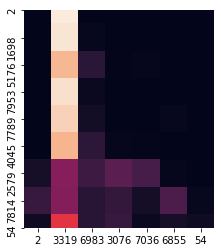

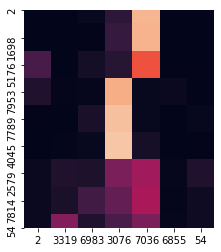

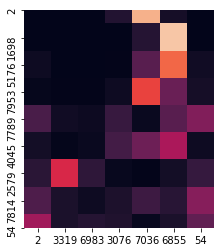

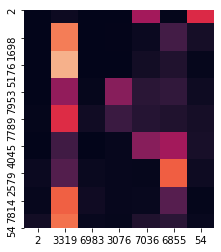

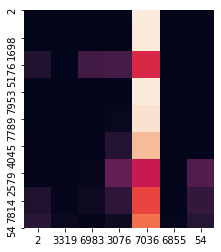

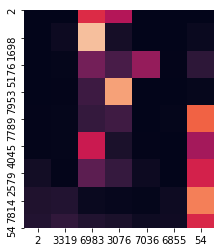

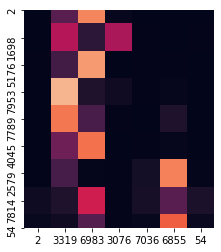

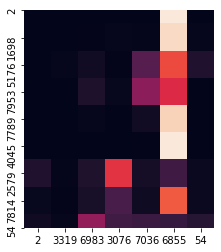

In [399]:
import matplotlib.pylab as plt
import seaborn

# for showing Korean in plot
plt.rcParams['font.family'] = 'NanumGothic'

def draw(data, x, y):
    seaborn.heatmap(data, 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=False)

last_layer = num_decoder_layers - 1
multi_heads_enc_dec_attention_weights = model.decoder.layers[last_layer].src_attn.attn.data
# mean_attention = torch.mean(multi_heads_enc_dec_attention_weights, dim=[0,1])

printQ = ''.join(qtokens[1:])
printA = ''.join([vocab.idx_to_token[idx] for idx in answer[1:]])
folder='{}-{}'.format(printQ,printA)

if not os.path.exists(folder):
    os.makedirs(folder)

for h in range(8):
    attention_weight = multi_heads_enc_dec_attention_weights[0,h]
    attention_weight = attention_weight.cpu().detach().numpy()[:len(answer),:]

    plt.figure()
    draw(attention_weight, [vocab.token_to_idx[tok] for tok in qtokens], answer)
    plt.savefig(os.path.join(folder,'L{}-H{}.png'.format(layer,h)))
    plt.show()

In [401]:
vocab.idx_to_token[7814]

'하세요'